In [2]:
import numpy as np
import scipy as sp
import os
import glob
import matplotlib.pyplot as plt
import imageio
import random
import umap

from matplotlib import colors as mcolors

from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing

In [11]:
colors = ["#d74681", "#54bb68", "#c24fb6", "#7ab439", "#7a62d1", "#c0ac45", "#6075c0", "#d2632a", "#5ea3d9", "#cb4848", "#4db49f", "#9d4862", "#5e7f3b", "#b57ac0", "#b57e44", "#e18598"]

## 8 Agents, 2 Neighbors, 5 Artefacts, 250 Epochs

In [12]:
data_path = "../data/output/output_2020-06-25T09-46-36.npy"

x = np.load(data_path, allow_pickle=True)

artefacts = np.array([a[5] for a in x])
agent_ids = np.array([a[1] for a in x])

n_agents = 8
labels = [f"agent_0_{i}" for i in range(0, n_agents)]

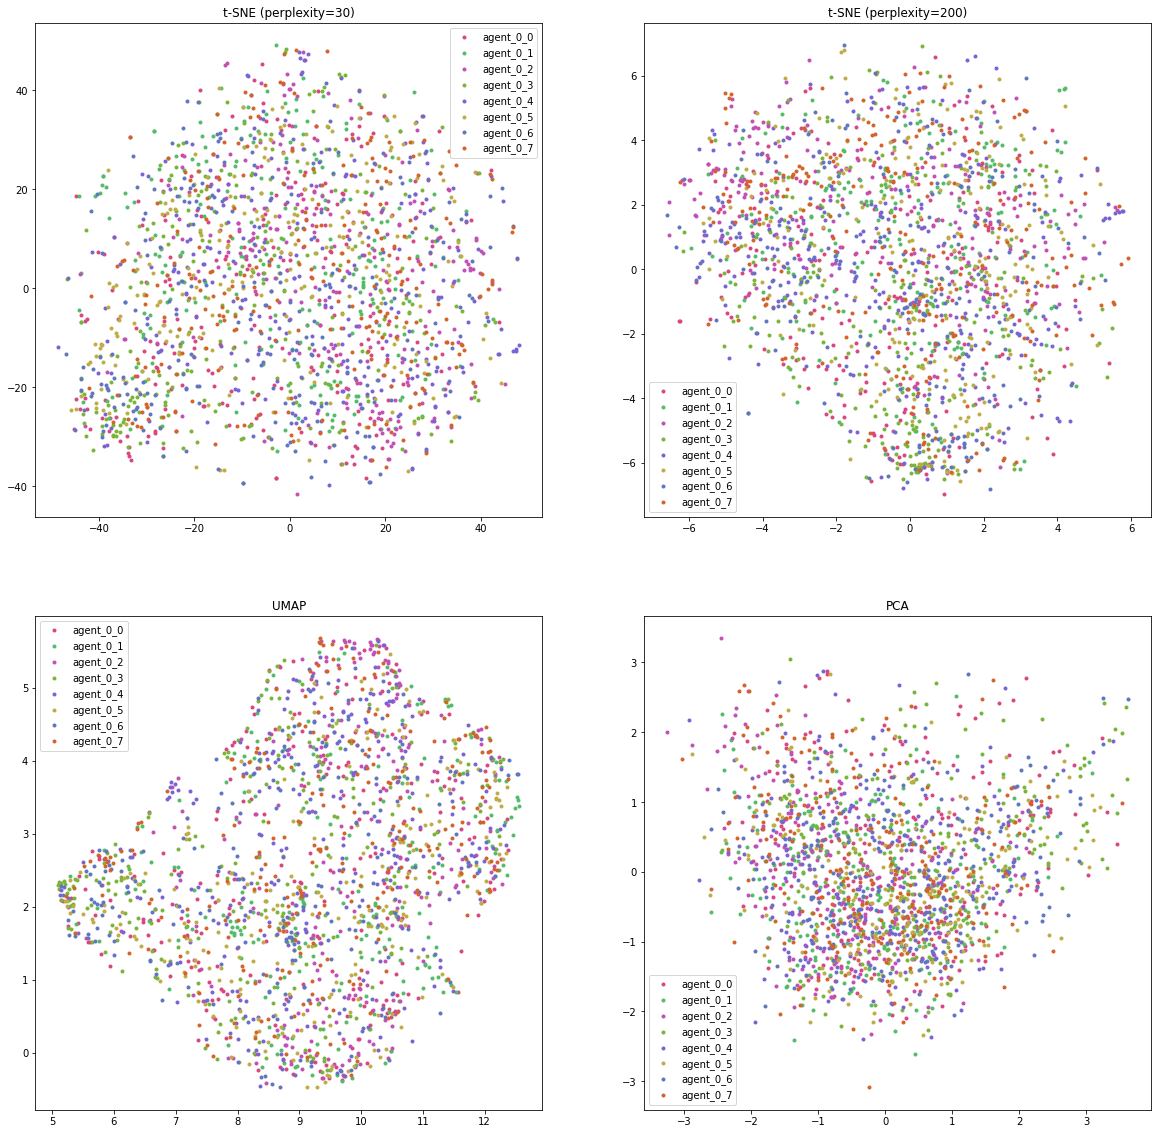

Number of artefacts: 2000


In [13]:
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

perplexities = [30, 200]


for i, ax in enumerate(axs.flatten()):
    if i < 2:
        tsne = manifold.TSNE(n_components=2, random_state=1, perplexity=perplexities[i])
        embedded = tsne.fit_transform(artefacts)
        ax.set_title(f"t-SNE (perplexity={perplexities[i]})")
    elif i == 2:
        _artefacts = preprocessing.scale(artefacts)

        reducer = umap.UMAP(n_components=2)
        embedded = reducer.fit_transform(_artefacts)
        ax.set_title("UMAP")
    else:
        pca = decomposition.PCA(n_components=2)
        embedded = pca.fit_transform(artefacts)
        ax.set_title("PCA")

    for i, label in enumerate(labels):
        x, y = embedded[i::n_agents, 0], embedded[i::n_agents, 1]
        ax.scatter(x, y, c=colors[i % n_agents], label=label, marker=".")
    
    ax.legend()

plt.show()
print(f"Number of artefacts: {len(artefacts)}")

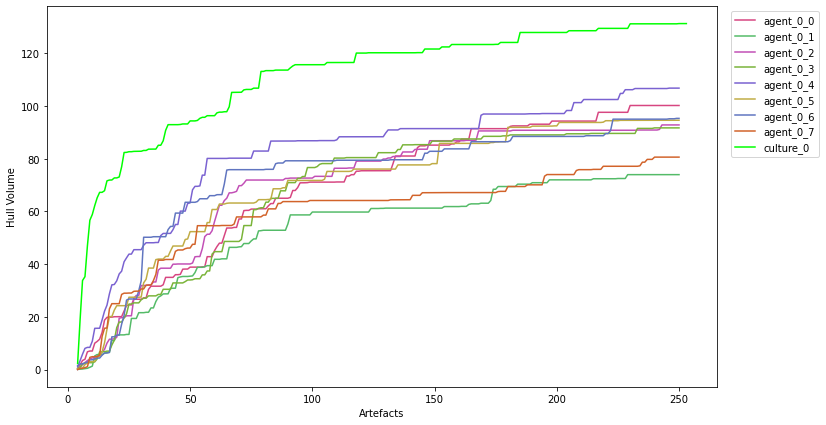

In [14]:
fig_2, ax = plt.subplots(1, 1, figsize=(12, 7))

# -- the agent volumes of their conceptual spaces
labels_hull = [f"agent_0_{i}" for i in range(0, n_agents)]
agent_hulls = []

for i in range(0, n_agents):
    volumes = []
    agent_artefacts = artefacts[i::n_agents]
    
    pca = decomposition.PCA(n_components=3)
    pca_embedded = pca.fit_transform(agent_artefacts)

    hull = sp.spatial.ConvexHull(pca_embedded[:4], incremental=True)
    volumes.append(hull.volume)

    for j in range(4, len(agent_artefacts)):
        hull.add_points([pca_embedded[j]])
        volumes.append(hull.volume)
    hull.close()
    
    agent_hulls.append(hull)

    ax.plot(range(4, len(volumes) + 4), volumes, c=colors[i % n_agents], label=labels_hull[i])

# -- the culture volumes of its conceptual space
culture_volumes = []

pca = decomposition.PCA(n_components=3)
pca_embedded = pca.fit_transform(artefacts)

culture_hull = sp.spatial.ConvexHull(pca_embedded[:4], incremental=True)
culture_volumes.append(culture_hull.volume)

for j in range(4, len(artefacts)):
    culture_hull.add_points([pca_embedded[j]])
    culture_volumes.append(culture_hull.volume)
culture_hull.close()

x = range(4, round(len(culture_volumes) / n_agents) + 4)
y = culture_volumes[0::n_agents]

ax.plot(x, y, c='lime', label="culture_0")
ax.set_ylabel('Hull Volume')
ax.set_xlabel('Artefacts')

plt.legend(loc='upper right', bbox_to_anchor=(1.16, 1))
plt.show()

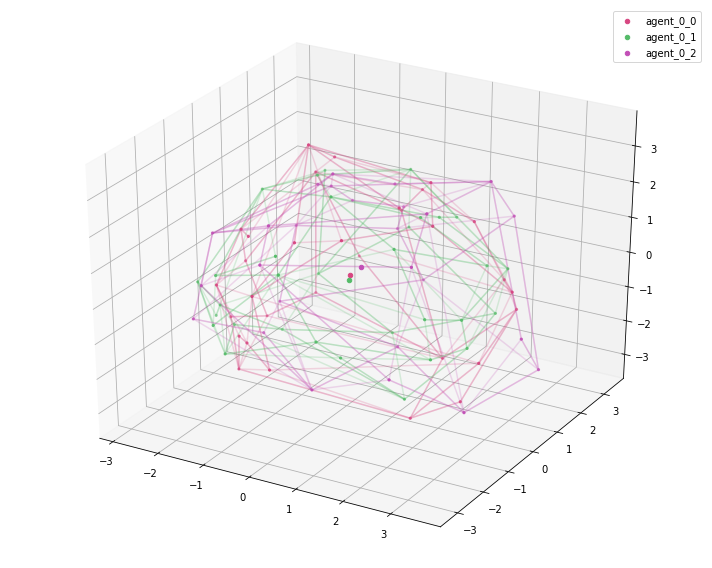

In [15]:
fig_1 = plt.figure(figsize=(10, 8))
ax_1 = fig_1.add_subplot(111, projection="3d")

# -- for now only project 3 agents, if all 8, it becomes very messy
for i, hull in enumerate(agent_hulls[:3]):
    points = hull.points

    for simplex in hull.simplices:
        ax_1.plot(points[simplex, 0], points[simplex, 1], points[simplex, 2], c=colors[i % n_agents], alpha=.2)
    
    vertices = np.array([[points[vertex, 0], points[vertex, 1], points[vertex, 2]] for vertex in hull.vertices])
    
    # every vertex is an artefact
    ax_1.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c=colors[i % n_agents], marker=".")

    # the large dot in the centers is the mean
    mean = vertices.mean(axis=0)
    ax_1.scatter(mean[0], mean[1], mean[2], c=colors[i % n_agents], label=labels[i])

plt.tight_layout()
plt.legend()
plt.show()

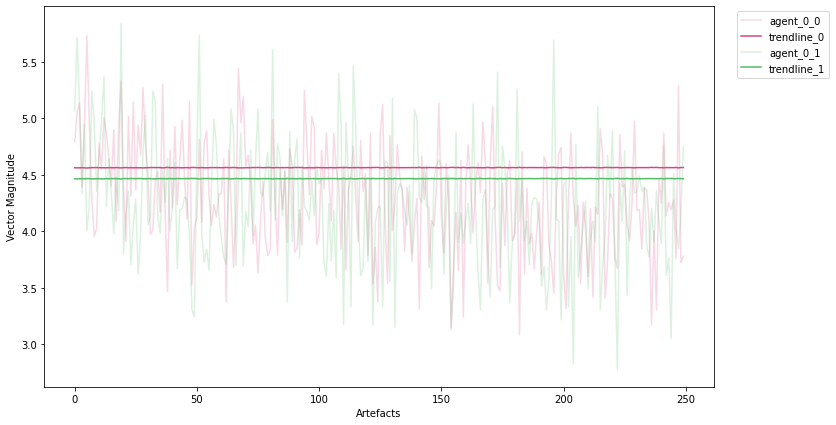

In [33]:
# -- the magnitude of each artefact vector.
# -- currently all derived from the origin
# -- could take the agent's first mean, or the mean of the convex hull as the origin.

fig_3, ax = plt.subplots(1, 1, figsize=(12, 7))

fit = []
norms = []
for i in range(0, 2): # n_agents 
    norm = np.array([np.linalg.norm(artefact) for artefact in artefacts[i::n_agents]])
    norms.append(norm)
    x = range(0, len(norm))
    ax.plot(x, norm, c=colors[i % n_agents], label=labels[i], alpha=0.2)
    ax.set_ylabel('Vector Magnitude')
    ax.set_xlabel('Artefacts')

    trend = np.polyfit(x, norm, 1)
    trend_p = np.poly1d(trend)

    fit.append(trend_p(norm))
    ax.plot(x, trend_p(norm), label=f"trendline_{i}", c=colors[i % n_agents])

plt.legend(loc='upper right', bbox_to_anchor=(1.18, 1))
plt.show()

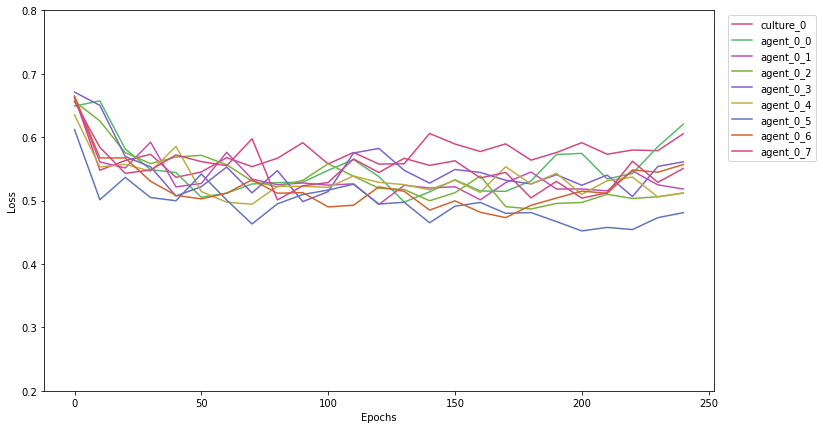

In [17]:
data_eval_path = "../data/output/output_2020-06-25T09-46-36_validation.npy"
evaluations = np.load(data_eval_path, allow_pickle=True)

labels_eval = ["culture_0"] + [f"agent_0_{i}" for i in range(0, n_agents)]

fig_4, ax = plt.subplots(1, 1, figsize=(12, 7))

for i, evaluation in enumerate(evaluations):
    ax.plot(range(0, len(evaluation) * 10, 10), evaluation, c=colors[i % n_agents], label=labels_eval[i])

ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
ax.set_ylim(.2, .8)
plt.legend(loc='upper right', bbox_to_anchor=(1.16, 1))
plt.show()